In [137]:
pip install --upgrade numpy

  Using cached numpy-2.2.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.2-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.10 requires mkl, which is not installed.
scipy 1.9.3 requires numpy<1.26.0,>=1.18.5, but you have numpy 2.2.2 which is incompatible.


In [10]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis import states
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import os
import psutil
from matplotlib.ticker import FuncFormatter
import arcgis
from arcgis.gis import GIS
from arcgis.map import Map
from arcgis.features import GeoAccessor
import geopandas as gpd

In [11]:

%clear
#Function to check memory usage

def check_memory_usage():
    # Get virtual memory details
    virtual_memory = psutil.virtual_memory()

    # Print cache memory details
    print(f"Used Cache Memory: {virtual_memory.used / (1024 ** 2):.2f} MB")
    print(f"Available Cache Memory: {virtual_memory.available / (1024 ** 2):.2f} MB")

check_memory_usage()



Used Cache Memory: 24515.16 MB
Available Cache Memory: 41020.33 MB


In [3]:
#Variables to use to pull data from the Census API
#We're using the 2020 Decenial Census and the Demographic and Housing Characteristics dataset


YEAR = 2020
DATASET = 'dec/dhc' 

In [4]:

# Set the environment variable (for testing purposes)
load_dotenv()

# Retrieve the API key from the environment variable
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY")

totalpop = "P1_001N"
vacant = "H3_003N"
hhunit = "H1_001N"

targeted_state = states.PR
variables = ["NAME", "GEO_ID", totalpop, vacant, hhunit]

pr_block = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    block="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,  ##Optional if you want to use the TIGER shapefiles
    api_key = CENSUS_API_KEY,
)


pr_county = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
)


#Check cache memory usage 
check_memory_usage()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Pro\bin\Python\envs\arc-dev\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\Pro\bin\Python\envs\arc-dev\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\Pro\bin\Python\envs\arc-dev\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "d:\Pro\bin\Python\en

AttributeError: _ARRAY_API not found

Used Cache Memory: 24185.71 MB
Available Cache Memory: 41349.77 MB


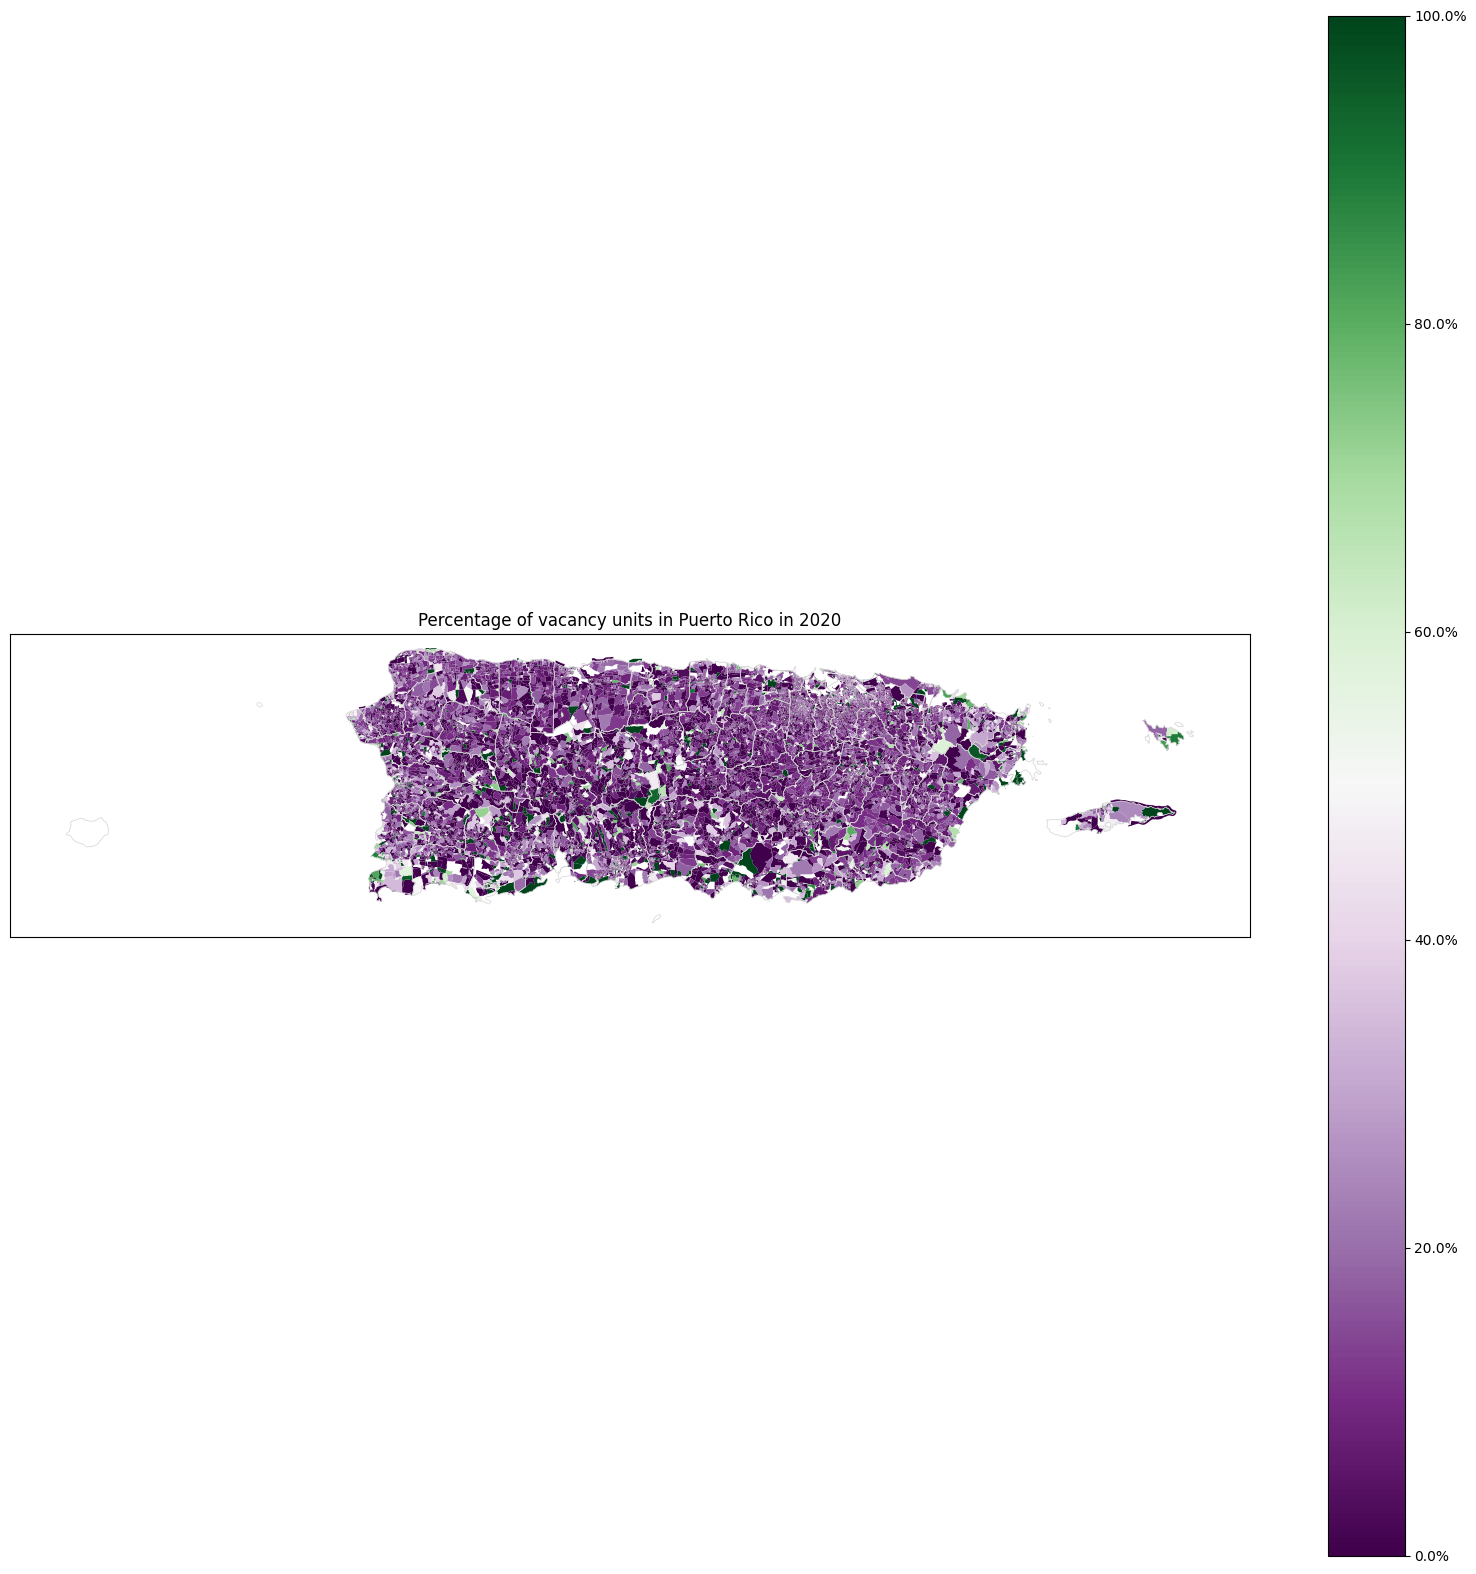

In [15]:
#With tiger shapefiles variable

# Plot the map with the given parameters
ax = cem.plot_map(pr_block, 
                    column=pr_block[vacant]/pr_block[hhunit]*100, 
                    # edgecolor="black", 
                    cmap="PRGn", 
                    legend=True, 
                    figsize=(20, 20),
                    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:,.1f}%")},
                    )
_ = ax.set_title("Percentage of vacancy units in Puerto Rico in 2020")

#Add county boundary to the map

ax = cem.plot_map(pr_county.boundary, color="lightgrey", linewidth=0.5, ax=ax)

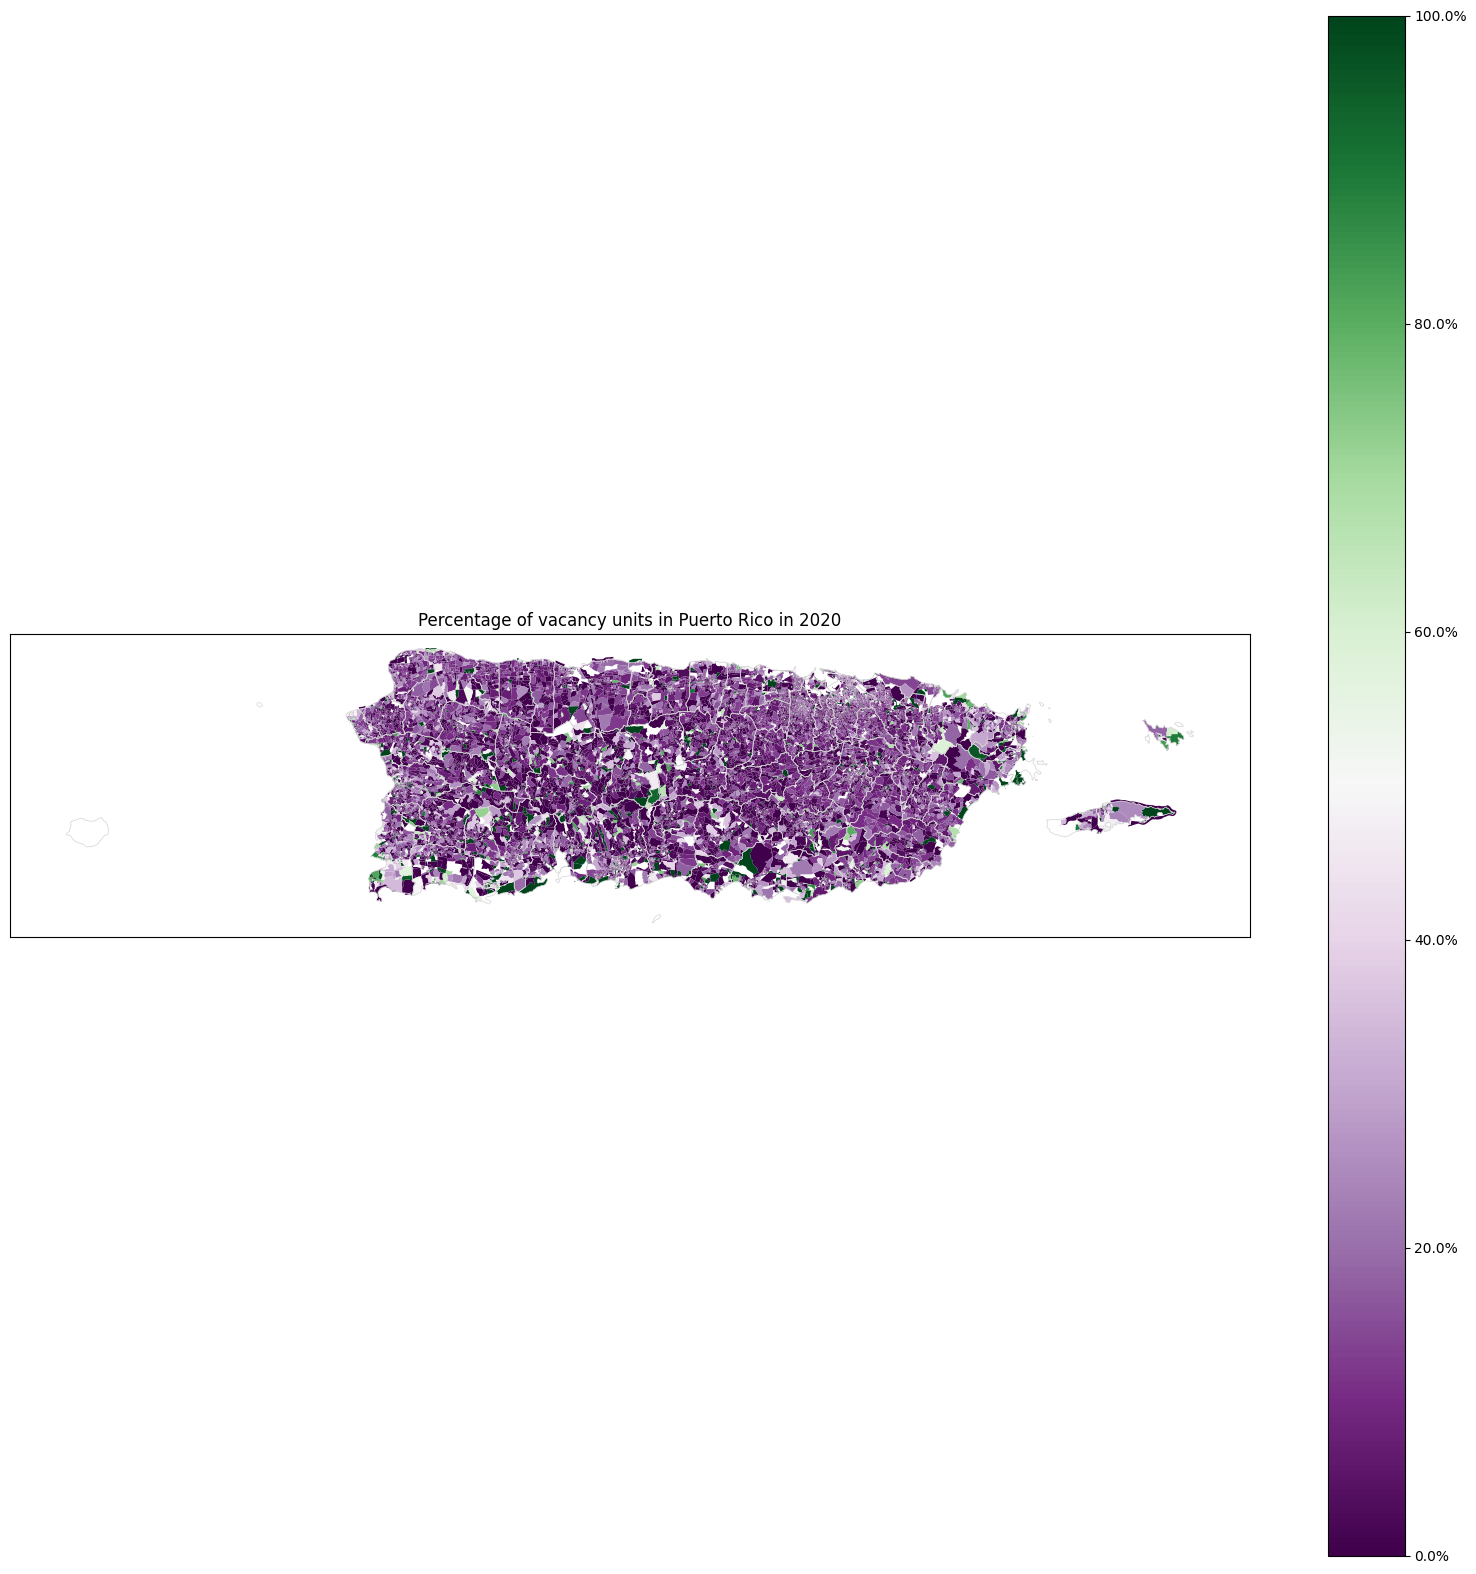

In [16]:
#Without tiger shapefiles variable

# Plot the map of vacancy percentage in Puerto Rico
ax = cem.plot_map(pr_block, 
                    column=pr_block[vacant]/pr_block[hhunit]*100, 
                    # edgecolor="black", 
                    cmap="PRGn", 
                    legend=True, 
                    figsize=(20, 20),
                    legend_kwds={"format": FuncFormatter(lambda x, pos: f"{x:,.1f}%")},
                    )
_ = ax.set_title("Percentage of vacancy units in Puerto Rico in 2020")

#Add county boundary to the map
ax = cem.plot_map(pr_county.boundary, color="lightgrey", linewidth=0.5, ax=ax)


In [5]:
#Compare 2010 and 2020 vacancy data

pr_block_2010 = ced.download(
    "dec/sf1",
    2010,
    ["NAME", "GEO_ID", "P010001", "H003003", "H001001"],
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
    # remove_water = True,
)


pr_block_2020 = ced.download(
    DATASET,
    YEAR,
    variables,
    state=targeted_state,
    county="*",
    with_geometry=True,
    # tiger_shapefiles_only=True,
    api_key = CENSUS_API_KEY,
    # remove_water = True,
)

check_memory_usage()

Used Cache Memory: 24289.66 MB
Available Cache Memory: 41245.83 MB


In [6]:
gdf_both_years = pr_block_2020.merge(pr_block_2010, on=["GEO_ID", "NAME"] , suffixes=("_2020", "_2010"))

In [7]:
vacant_variable_2020 = vacant
vacant_variable_2010 = "H003003"
total_change_percent = vacant + "_change_percent"
total_change = vacant + "_change"

In [8]:
gdf_both_years[total_change] = (
                                gdf_both_years[vacant_variable_2020]
                                  - gdf_both_years[vacant_variable_2010]
)

gdf_both_years[total_change_percent] = (
                                        100 
                                        * gdf_both_years[total_change]
                                        / gdf_both_years[vacant_variable_2010]
)
# Classify the data by quantile
gdf_both_years['quantile'] = pd.qcut(gdf_both_years[total_change], q=5, labels=False)

<Axes: title={'center': 'Change in the number of vacant units in Puerto Rico between 2010 and 2020'}>

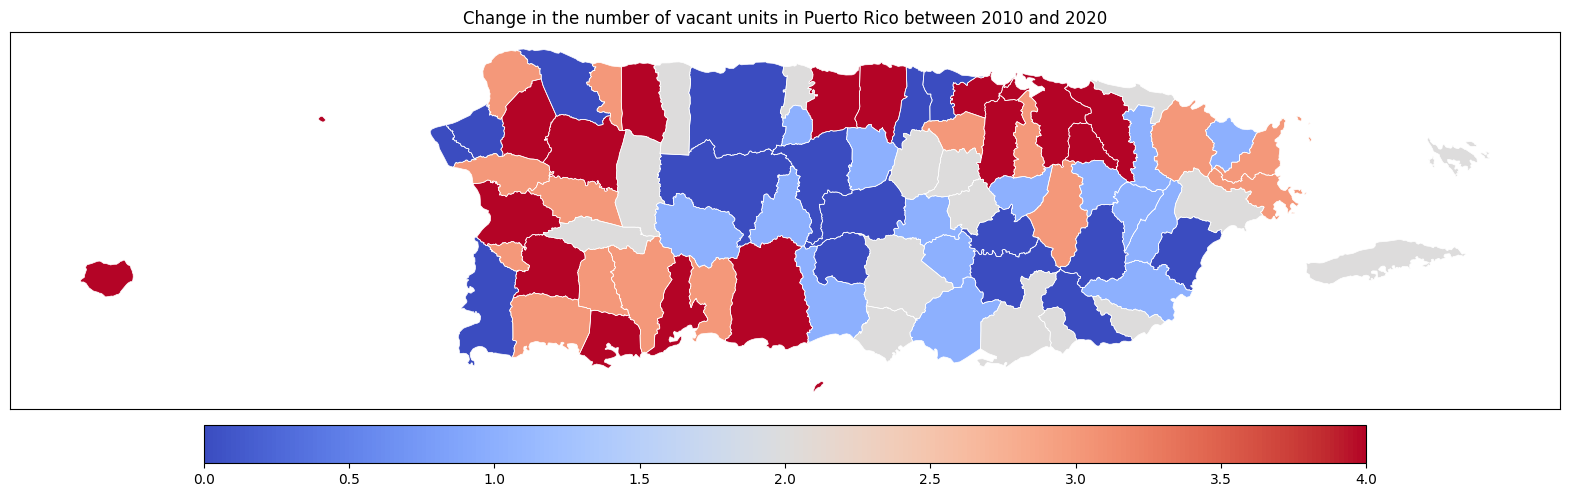

In [ ]:


# Set the geometry for the GeoDataFrame
gdf_both_years.set_geometry("geometry_2020", inplace=True)


# Plot the GeoDataFrame
ax = cem.plot_map(gdf_both_years, 
             gdf_both_years["quantile"], 
             cmap="coolwarm",
             figsize=(20, 20), 
             legend=True, 
             linewidth=0.25,
             legend_kwds={'location': 'bottom',
                               'orientation': 'horizontal',
                               'shrink': 0.75,
                               'aspect': 30,
                               'pad': 0.01})

# Set the title
ax.set_title("Change in the number of vacant units in Puerto Rico between 2010 and 2020")


# Add county boundary to the map
cem.plot_map(pr_county.boundary, color="white", linewidth=0.5, ax=ax)


In [293]:
# Pulling jpg image from WMS server and export to a local drive

lecz = requests.get("https://gis.earthdata.nasa.gov/image/rest/services/lecz/lecz_urban_rural_population_land_area_estimates_v3/ImageServer/exportImage?bbox=-67.945404%2C+17.88328+%2C+-65.221077%2C+18.516023&bboxSR=&size=&imageSR=4326&time=&format=jpgpng&pixelType=S8&noData=31&noDataInterpretation=esriNoDataMatchAll&interpolation=RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&sliceId=&mosaicRule=&renderingRule=%7B%0D%0A++%22type%22%3A+%22simple%22%2C%0D%0A++%22symbol%22%3A%0D%0A++%7B%0D%0A++++%22type%22%3A+%22esriSMS%22%2C%0D%0A++++%22style%22%3A+%22esriSMSCircle%22%2C%0D%0A++++%22color%22%3A+%5B255%2C0%2C0%2C255%5D%2C%0D%0A++++%22size%22%3A+5%2C%0D%0A++++%22angle%22%3A+0%2C%0D%0A++++%22xoffset%22%3A+0%2C%0D%0A++++%22yoffset%22%3A+0%2C%0D%0A++++%22outline%22%3A%0D%0A++%7B%0D%0A++++%22color%22%3A+%5B0%2C0%2C0%2C255%5D%2C%0D%0A++++%22width%22%3A+1%0D%0A++++%7D%0D%0A++%7D%2C%0D%0A++%22label%22%3A+%22%22%2C%0D%0A++%22description%22%3A+%22%22%2C%0D%0A++%22rotationType%22%3A+%22geographic%22%2C%0D%0A++%22rotationExpression%22%3A+%22%5BRotation%5D+*+2%22%0D%0A%7D&adjustAspectRatio=true&validateExtent=true&lercVersion=1&compressionTolerance=&f=image")
lecz_url = lecz.url
export = pathlib.Path(f"lecz.png")

with export.open("wb") as file:
    file.write(lecz.content)

In [ ]:
#Getting the imagery layer from the ArcGIS Online

gis = GIS()

public_content = gis.content.search("lecz", item_type="Imagery Layer", max_items=10)

lecz = public_content[0]
display(lecz)

<Item title:"Low Elevation Coastal Zones derived from MERIT-DEM" type:Imagery Layer owner:NASA_Earthdata>

In [23]:
map1 = plt.figure(figsize=(20, 20))
map1 = gis.map("Puerto Rico")
map1.content.add(lecz)
map1

Map(center=[2063620.7690671808, -7399290.049500733], extent={'xmin': -7498920.993760712, 'ymin': 1958993.94058…

<Figure size 2000x2000 with 0 Axes>

In [31]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer

gis=GIS()

# Convert to sdf
sdf = pd.DataFrame.spatial.from_geodataframe(gdf_both_years)

flyr = FeatureLayer(lecz, gis=gis)
add_result = lecz.layers[0]

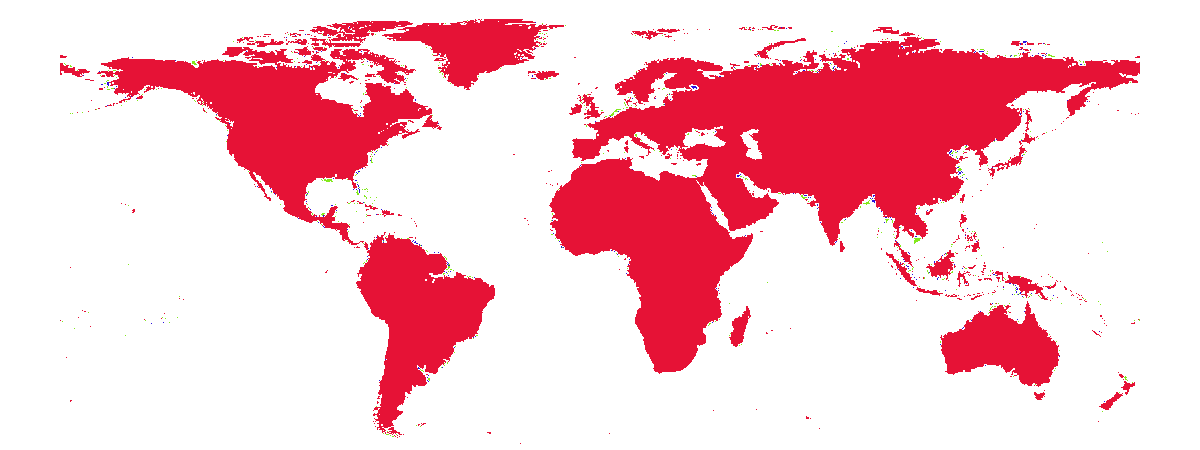

In [34]:
add_result